# Data Exploration

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import collections

## Load datasets

In [4]:
project_path = '../data'
dataset_path = os.path.join(project_path, 'mimiciii')

In [3]:
conn = psycopg2.connect(database = "mimic", 
                        user = "postgres", 
                        host= 'localhost',
                        password = "postgres",
                        port = 5432,
                        options="--search_path=mimiciii")

In [4]:
cur = conn.cursor()
cur.execute('SELECT count(subject_id) FROM patients')
df = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])

In [5]:
df.head()

NameError: name 'df' is not defined

In [6]:
LABEL_SPLITS = pd.read_csv(os.path.join(dataset_path,"LABEL_SPLITS.csv"), dtype={"ICD9_CODE": str})
# NOTEEVENTS = pd.read_csv(os.path.join(dataset_path,"NOTEEVENTS.csv"))
LABEVENTS = pd.read_csv(os.path.join(dataset_path,"LABEVENTS.csv"))
# OUTPUTEVENTS = pd.read_csv(os.path.join(dataset_path,"OUTPUTEVENTS.csv"))
# CHARTEVENTS = pd.read_csv(os.path.join(dataset_path,"CHARTEVENTS.csv"))
# CPTEVENTS = pd.read_csv(os.path.join(dataset_path,"CPTEVENTS.csv"))
# MICROBIOLOGYEVENTS = pd.read_csv(os.path.join(dataset_path,"MICROBIOLOGYEVENTS.csv"))

In [7]:
LABEL_SPLITS.head()

,HADM_ID,SPLIT_50,ROW_ID,SUBJECT_ID,SEQ_NUM,ICD9_CODE
0,182396,TRAIN,88642,7908,1.0,572.2
1,182396,TRAIN,88643,7908,2.0,038.49
2,182396,TRAIN,88644,7908,3.0,785.52
3,182396,TRAIN,88645,7908,4.0,584.9
4,182396,TRAIN,88646,7908,5.0,585


# Mimic III

## Lab Tests
### Summary statistics

In [42]:
LABEVENTS = pd.read_csv(os.path.join(dataset_path,"LABEVENTS.csv"))
D_LABITEMS = pd.read_csv(os.path.join(dataset_path,"D_LABITEMS.csv"))


In [71]:
adm_lab = LABEVENTS.merge(D_LABITEMS.loc[:, ['ITEMID', 'LABEL', 'CATEGORY']], on='ITEMID', how='inner')
adm_lab = adm_lab[adm_lab.HADM_ID.isna() == False]
adm_lab = adm_lab[adm_lab.CHARTTIME.isna() == False]
adm_lab["HADM_ID"] = adm_lab["HADM_ID"].apply(int)
adm_lab["CHARTTIME"] = pd.to_datetime(adm_lab.CHARTTIME)
adm_lab = adm_lab.merge(LABEL_SPLITS, on='HADM_ID', how='inner')

In [72]:
adm_lab = adm_lab.loc[adm_lab['SPLIT_50'] == 'TRAIN']

In [16]:
# total num of lab tests conducted per admission
adm_lab.groupby(['HADM_ID']).count().loc[:, ['LABEL']].describe()

,LABEL
count,7989.000000
mean,9845.660784
std,19276.111014
min,26.000000
25%,1872.000000
50%,4004.000000
75%,9380.000000
max,384995.000000


In [29]:
# num of each lab test is performed during an admission
label_adm_stat = adm_lab.groupby(['HADM_ID', 'LABEL']).size().groupby('LABEL')

In [43]:
label_adm_stat.describe()

,count,mean,std,min,25%,50%,75%,max
LABEL,,,,,,,,
% Hemoglobin A1c,1621.0,19.951882,11.687448,2.0,12.00,17.0,24.00,142.0
24 hr Calcium,2.0,35.500000,28.991378,15.0,25.25,35.5,45.75,56.0
24 hr Creatinine,59.0,34.474576,25.256174,4.0,17.00,28.0,45.50,132.0
24 hr Protein,18.0,31.722222,13.450587,9.0,22.25,35.5,40.00,56.0
25-OH Vitamin D,27.0,30.481481,15.680390,12.0,19.50,29.0,36.00,92.0
...,...,...,...,...,...,...,...,...
"pCO2, Body Fluid",3.0,28.333333,13.796135,18.0,20.50,23.0,33.50,44.0
pH,10154.0,299.508765,716.812569,2.0,30.00,88.0,252.00,14690.0
pO2,7919.0,311.722566,713.511270,2.0,32.00,96.0,260.50,13520.0


In [37]:
label_adm_stat.size().sort_values(ascending=False)

LABEL
Hematocrit                11253
Hemoglobin                11247
Platelet Count            11246
White Blood Cells         11245
MCH                       11241
                          ...  
PLASMGN                       1
Osmolality, Body Fluid        1
Osmolality, Ascites           1
CD5 Absolute Count            1
CD20 Absolute Count           1
Length: 532, dtype: int64

In [42]:
# num of each category performed during an admission
adm_lab['CATEGORY'] = adm_lab['CATEGORY'].str.lower()
adm_lab.groupby(['HADM_ID', 'CATEGORY']).size().reset_index().groupby('CATEGORY')[[0]].describe()

0                                                         
              count        mean         std  min   25%    50%    75%     max
CATEGORY                                                                    
blood gas   44693.0  110.162800  198.993803  1.0  11.0   43.0  124.0  5962.0
chemistry   56924.0  148.469556  188.963209  1.0  50.0   94.0  176.0  4766.0
hematology  57150.0  155.206422  187.832855  1.0  55.0  102.0  183.0  4971.0

### Mapping with Time Elapse
need: admission time, lab test time, discharge time to determine at what point during the stay the test is performed

In [8]:
stay_info = pd.read_csv(os.path.join(dataset_path,"ADMISSIONS.csv"), usecols=['HADM_ID', 'ADMITTIME', 'DISCHTIME'])

In [73]:
print(len(adm_lab))
lab_time = adm_lab.merge(stay_info, on='HADM_ID', how='inner')
lab_time = lab_time[(pd.to_datetime(lab_time['ADMITTIME']) < pd.to_datetime(lab_time['DISCHTIME'])) & (pd.to_datetime(lab_time['CHARTTIME']) < pd.to_datetime(lab_time['DISCHTIME']))]
lab_time['PROP_ELAPSED'] = (pd.to_datetime(lab_time['CHARTTIME']) - pd.to_datetime(lab_time['ADMITTIME'])) / (pd.to_datetime(lab_time['DISCHTIME']) - pd.to_datetime(micro_time['ADMITTIME']))
print(len(lab_time[lab_time['PROP_ELAPSED'] < 0]))
lab_time.loc[lab_time['PROP_ELAPSED'] < 0, 'PROP_ELAPSED'] = 0
print(len(lab_time))

3556000
199042
3425732


In [74]:
adm_lab.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,LABEL,CATEGORY,SPLIT_50
0,7932,17,161087,50868,2135-05-09 10:45:00,20,20.0,mEq/L,NaN,Anion Gap,Chemistry,TRAIN
1,7933,17,161087,50882,2135-05-09 10:45:00,21,21.0,mEq/L,abnormal,Bicarbonate,Chemistry,TRAIN
2,7934,17,161087,50902,2135-05-09 10:45:00,101,101.0,mEq/L,NaN,Chloride,Chemistry,TRAIN
3,7935,17,161087,50910,2135-05-09 10:45:00,26,26.0,IU/L,NaN,Creatine Kinase (CK),Chemistry,TRAIN
4,7936,17,161087,50911,2135-05-09 10:45:00,NotDone,NaN,ng/mL,NaN,"Creatine Kinase, MB Isoenzyme",Chemistry,TRAIN


In [18]:
def vectorized_hour_to_cutoff(hours, ):
    cutoffs = np.select(
        [
            hours < 2 * 24,
            hours < 5 * 24,
            hours < 13 * 24
        ],
        [
            2,
            5,
            13
        ],
        default=0
    )
    return cutoffs

In [76]:
lab_time['TIME_ELAPSED'] = (pd.to_datetime(lab_time['CHARTTIME']) - pd.to_datetime(lab_time['ADMITTIME'])).clip(lower=pd.Timedelta(0))
lab_time["HOURS_ELAPSED"] = lab_time["TIME_ELAPSED"].dt.total_seconds() / 3600.0


lab_time["cutoff"] = vectorized_hour_to_cutoff(lab_time["HOURS_ELAPSED"])

In [77]:
lab_time["cutoff"].value_counts()

cutoff
2     1172823
13     860838
5      723099
0      668972
Name: count, dtype: int64

In [48]:
lab_time.groupby(['HADM_ID', 'cutoff']).size().reset_index().groupby('cutoff')[[0]].describe()

0                                                          
         count        mean         std  min   25%    50%     75%     max
cutoff                                                                  
0       1696.0  394.441038  631.663297  1.0  51.0  170.0  457.25  6541.0
2       7764.0  151.059119   84.879301  2.0  95.0  133.0  188.00   840.0
5       7046.0  102.625461   83.933889  1.0  46.0   82.0  133.00   897.0
13      4878.0  176.473555  180.219400  1.0  40.0  119.0  260.00  1812.0

In [79]:
with open('/Users/cindy/Documents/Imperial/msc-proj/temporal-multimodal-learning/temp-mm/preproc/incr/incr_imp-lab_less.txt', 'r') as f:
    imp_labs = f.read().splitlines()
lab_time[lab_time['LABEL'].isin(imp_labs)].groupby(['HADM_ID', 'cutoff']).size().reset_index().groupby('cutoff')[[0]].describe()

0                                                        
         count        mean         std  min   25%   50%    75%     max
cutoff                                                                
0       1683.0  188.585264  286.566468  1.0  28.0  89.0  227.5  3369.0
2       7762.0   63.418578   33.030578  1.0  44.0  57.0   78.0   331.0
5       7027.0   49.133343   34.013866  1.0  26.0  43.0   63.0   345.0
13      4852.0   85.177246   77.593188  1.0  24.0  64.0  128.0   695.0

In [82]:
test = lab_time[lab_time['LABEL'].isin(imp_labs)].groupby(['HADM_ID', 'cutoff']).size().reset_index()
test[test['cutoff'].isin([2,5,13])]['HADM_ID'].nunique()

7895

In [31]:
lab_time[lab_time['CATEGORY']=='Blood Gas'].head()

,HADM_ID,LABEL,CATEGORY,CHARTTIME,SPLIT_50,ROW_ID,SUBJECT_ID,SEQ_NUM,ICD9_CODE,ADMITTIME,DISCHTIME
352,161087.0,Base Excess,Blood Gas,2135-05-09 12:54:00,TRAIN,73,17,1.0,423.9,2135-05-09 14:11:00,2135-05-13 14:40:00
353,161087.0,Base Excess,Blood Gas,2135-05-09 12:54:00,TRAIN,74,17,2.0,511.9,2135-05-09 14:11:00,2135-05-13 14:40:00
354,161087.0,Base Excess,Blood Gas,2135-05-09 12:54:00,TRAIN,75,17,3.0,785.51,2135-05-09 14:11:00,2135-05-13 14:40:00
355,161087.0,Base Excess,Blood Gas,2135-05-09 12:54:00,TRAIN,76,17,4.0,458.9,2135-05-09 14:11:00,2135-05-13 14:40:00
356,161087.0,Base Excess,Blood Gas,2135-05-09 12:54:00,TRAIN,77,17,5.0,311,2135-05-09 14:11:00,2135-05-13 14:40:00


In [108]:
print(lab_time['PROP_ELAPSED'].max())
print(lab_time['PROP_ELAPSED'].describe())

0.9999489544162937
count    2.220740e+07
mean     3.602482e-01
std      2.936580e-01
min      0.000000e+00
25%      8.917249e-02
50%      3.091467e-01
75%      5.904747e-01
max      9.999490e-01
Name: PROP_ELAPSED, dtype: float64


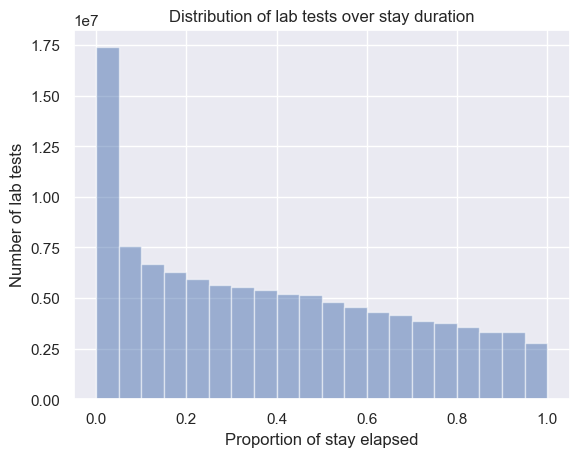

In [18]:
sns.set_theme()
plt.hist(lab_time['PROP_ELAPSED'], alpha=0.5, bins=20)
plt.xlabel('Proportion of stay elapsed')
plt.ylabel('Number of lab tests')
plt.title('Distribution of lab tests over stay duration')
plt.show()

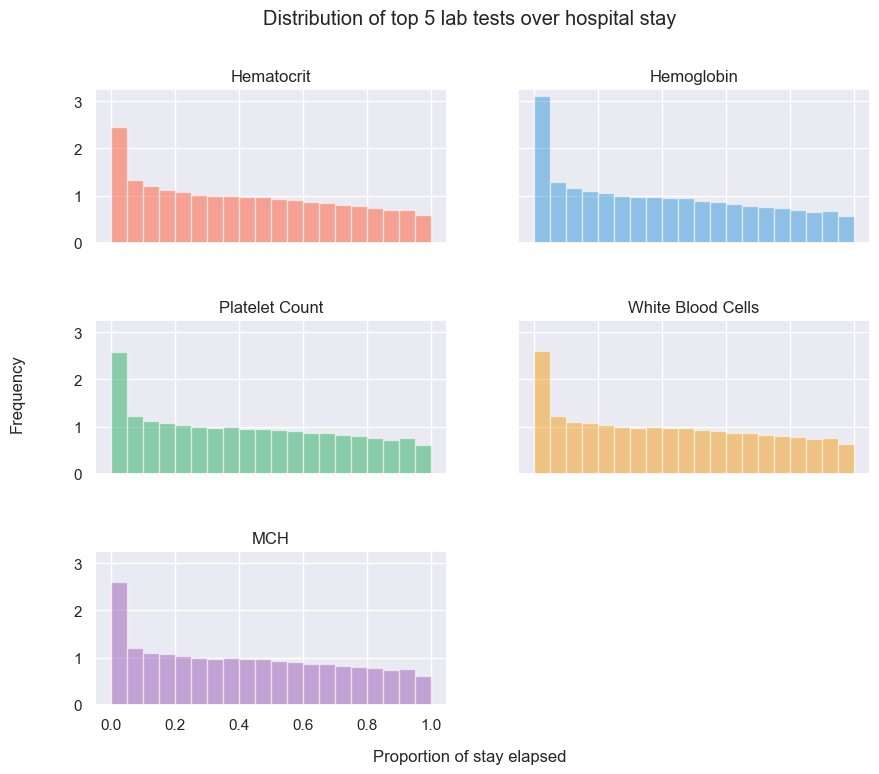

In [22]:
sns.set_theme()
top5_lab = ['Hematocrit', 'Hemoglobin', 'Platelet Count', 'White Blood Cells', 'MCH']
colors = ['#FF5733', '#3498DB', '#27AE60', '#F39C12', '#9B59B6']
fig, axs = plt.subplots(3, 2, figsize=(10, 8), sharex=True, sharey=True)  # 2 rows, 2 columns
plt.subplots_adjust(hspace=0.5)
for i in range(5):
    row = i // 2
    col = i % 2
    ax = axs[row, col]

    ax.hist(lab_time[lab_time['LABEL'] == top5_lab[i]]['PROP_ELAPSED'], density=True, bins=20, alpha=0.5, color=colors[i], label=top5_lab[i])
    ax.set_title(f'{top5_lab[i]}')

axs[-1, -1].axis('off')
fig.text(0.5, 0.04, 'Proportion of stay elapsed', ha='center')
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')
plt.suptitle('Distribution of top 5 lab tests over hospital stay')
plt.show()

In [29]:
lab_time['CATEGORY'] = lab_time['CATEGORY'].str.lower()

In [14]:
lab_time.head()

,HADM_ID,LABEL,CATEGORY,CHARTTIME,SPLIT_50,ROW_ID,SUBJECT_ID,SEQ_NUM,ICD9_CODE,ADMITTIME,DISCHTIME,PROP_ELAPSED
0,161087.0,Anion Gap,chemistry,2135-05-09 10:45:00,TRAIN,73,17,1.0,423.9,2135-05-09 14:11:00,2135-05-13 14:40:00,0.0
1,161087.0,Anion Gap,chemistry,2135-05-09 10:45:00,TRAIN,74,17,2.0,511.9,2135-05-09 14:11:00,2135-05-13 14:40:00,0.0
2,161087.0,Anion Gap,chemistry,2135-05-09 10:45:00,TRAIN,75,17,3.0,785.51,2135-05-09 14:11:00,2135-05-13 14:40:00,0.0
3,161087.0,Anion Gap,chemistry,2135-05-09 10:45:00,TRAIN,76,17,4.0,458.9,2135-05-09 14:11:00,2135-05-13 14:40:00,0.0
4,161087.0,Anion Gap,chemistry,2135-05-09 10:45:00,TRAIN,77,17,5.0,311,2135-05-09 14:11:00,2135-05-13 14:40:00,0.0


TypeError: Legend.set_frame_on() missing 1 required positional argument: 'b'

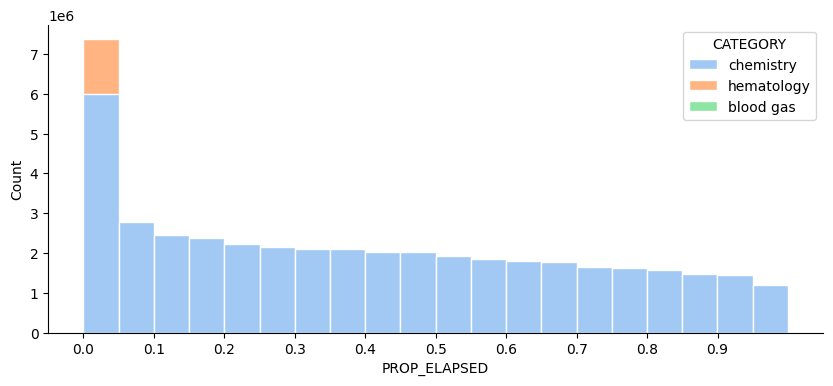

In [13]:
# by category
sns.set_theme()
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(data=lab_time, x='PROP_ELAPSED', hue='CATEGORY', discrete=False,
             edgecolor='white', palette='pastel', alpha=1,  bins=20)

# Create x ticks covering the range of all integer values of df['value']
ax.set_xticks(np.arange(0, 1, step=0.1))

# Additional formatting
sns.despine()
ax.get_legend().set_frame_on(True)

plt.xlabel('Proportion of stay elapsed')
plt.ylabel('Count')
plt.title('Lab tests by category over stay duration')
plt.show()

### Overlap with notes

In [18]:
notes_time = NOTEEVENTS.merge(stay_info, on='HADM_ID', how='inner')
notes_time = notes_time[(pd.to_datetime(notes_time['ADMITTIME']) < pd.to_datetime(notes_time['DISCHTIME'])) & (pd.to_datetime(notes_time['CHARTTIME']) < pd.to_datetime(notes_time['DISCHTIME']))]
notes_time['PROP_ELAPSED'] = (pd.to_datetime(notes_time['CHARTTIME']) - pd.to_datetime(notes_time['ADMITTIME'])) / (pd.to_datetime(notes_time['DISCHTIME']) - pd.to_datetime(notes_time['ADMITTIME']))
notes_time.loc[notes_time['PROP_ELAPSED'] < 0, 'PROP_ELAPSED'] = 0

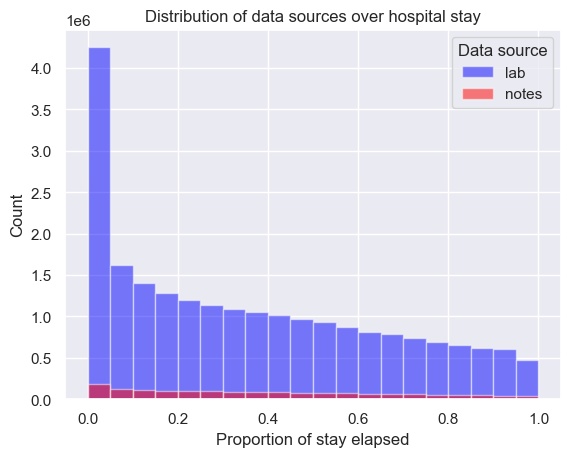

In [49]:
sns.set_theme()
plt.hist(lab_time['PROP_ELAPSED'], bins=20, alpha=0.5, color='blue', label='lab')
plt.hist(notes_time['PROP_ELAPSED'], bins=20, alpha=0.5, color='red', label='notes')
plt.xlabel('Proportion of stay elapsed')
plt.ylabel('Count')
plt.legend(title='Data source')
plt.title('Distribution of data sources over hospital stay')
plt.show()

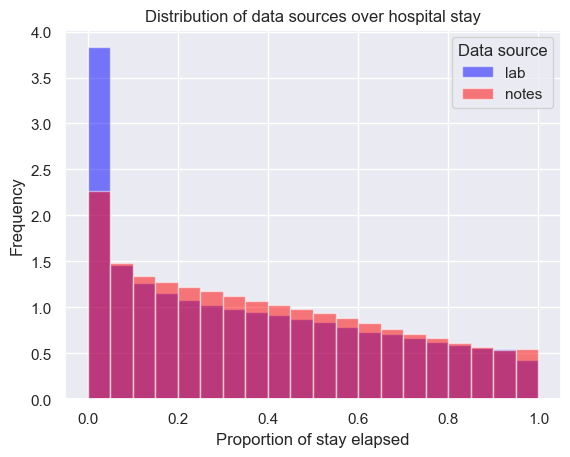

In [48]:
sns.set_theme()
plt.hist(lab_time['PROP_ELAPSED'], density=True, bins=20, alpha=0.5, color='blue', label='lab')
plt.hist(notes_time['PROP_ELAPSED'], density=True, bins=20, alpha=0.5, color='red', label='notes')
plt.xlabel('Proportion of stay elapsed')
plt.ylabel('Frequency')
plt.legend(title='Data source')
plt.title('Distribution of data sources over hospital stay')
plt.show()

In [50]:
len(list((collections.Counter(lab_time['HADM_ID'].unique()) & collections.Counter(notes_time['HADM_ID'].unique())).elements()))/len(notes_time['HADM_ID'].unique()) * 100

99.0592915121217

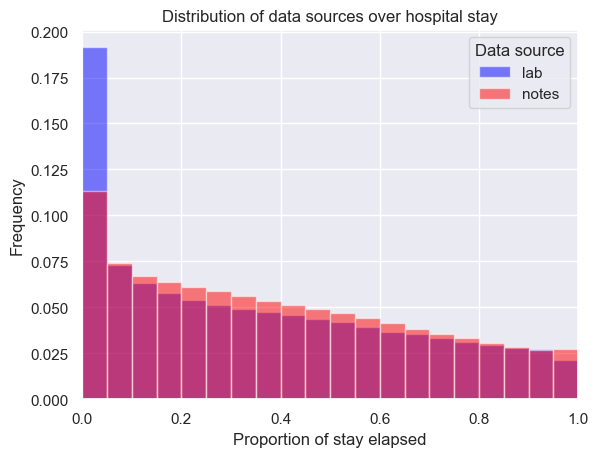

In [30]:
sns.set_theme()
plt.hist(lab_time['PROP_ELAPSED'], weights=np.zeros_like(lab_time['PROP_ELAPSED']) + 1. / lab_time['PROP_ELAPSED'].size, bins=20, alpha=0.5, color='blue', label='lab')
plt.hist(notes_time['PROP_ELAPSED'], weights=np.zeros_like(notes_time['PROP_ELAPSED']) + 1. / notes_time['PROP_ELAPSED'].size, bins=20, alpha=0.5, color='red', label='notes')
plt.xlim(0,1)
plt.xlabel('Proportion of stay elapsed')
plt.ylabel('Frequency')
plt.legend(title='Data source')
plt.title('Distribution of data sources over hospital stay')
plt.show()

## Note Events

In [9]:
NOTEEVENTS = pd.read_csv(os.path.join(dataset_path,"NOTEEVENTS.csv"))
# adm_notes = NOTEEVENTS.merge(LABEL_SPLITS, on='HADM_ID', how='inner')
# adm_notes = adm_notes.loc[adm_notes['SPLIT_50'] == 'TRAIN']

/var/folders/dx/vf7v90ms0yddzdx3cv6z9lkr0000gn/T/ipykernel_81703/1021152577.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  NOTEEVENTS = pd.read_csv(os.path.join(dataset_path,"NOTEEVENTS.csv"))


In [10]:
adm_notes = NOTEEVENTS[NOTEEVENTS.HADM_ID.isna() == False]
adm_notes["HADM_ID"] = adm_notes["HADM_ID"].apply(int)
adm_notes.CHARTTIME = adm_notes.CHARTTIME.fillna(
            adm_notes.CHARTDATE + " 12:00:00"
        )
adm_notes["CHARTTIME"] = pd.to_datetime(adm_notes.CHARTTIME)

/var/folders/dx/vf7v90ms0yddzdx3cv6z9lkr0000gn/T/ipykernel_81703/3290175477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adm_notes["HADM_ID"] = adm_notes["HADM_ID"].apply(int)
/var/folders/dx/vf7v90ms0yddzdx3cv6z9lkr0000gn/T/ipykernel_81703/3290175477.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adm_notes.CHARTTIME = adm_notes.CHARTTIME.fillna(
/var/folders/dx/vf7v90ms0yddzdx3cv6z9lkr0000gn/T/ipykernel_81703/3290175477.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [11]:
LABEL_SPLITS["HADM_ID"] = LABEL_SPLITS["HADM_ID"].apply(int)
LABEL_SPLITS = LABEL_SPLITS[['HADM_ID','SPLIT_50']].drop_duplicates()

In [12]:
adm_notes = adm_notes.merge(LABEL_SPLITS[['HADM_ID', 'SPLIT_50']], on='HADM_ID', how='inner')
adm_notes = adm_notes.loc[adm_notes['SPLIT_50'] == 'TRAIN']

In [13]:
adm_notes

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,SPLIT_50
0,185,1136,139574,2192-05-23,2192-05-23 12:00:00,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2192-4-19**] ...,TRAIN
1,227,10044,124073,2152-10-11,2152-10-11 12:00:00,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2152-10-2**] Dischar...,TRAIN
2,187,1136,136706,2194-08-16,2194-08-16 12:00:00,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2194-8-15**] ...,TRAIN
4,190,9590,132347,2102-03-10,2102-03-10 12:00:00,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2102-2-19**] Dischar...,TRAIN
5,191,26175,156154,2112-05-05,2112-05-05 12:00:00,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2112-4-22**] ...,TRAIN
...,...,...,...,...,...,...,...,...,...,...,...,...
380031,2077081,31762,133669,2159-09-22,2159-09-22 02:32:00,2159-09-22 02:40:00,Nursing/other,Report,18249.0,NaN,NICU NPN 1900-0700\n\nFluid and Nutrition\nIn...,TRAIN
380032,2077082,31762,133669,2159-09-22,2159-09-22 12:48:00,2159-09-22 12:51:00,Nursing/other,Report,18056.0,NaN,"Neonatology Attending Note\nDOL# 10, CGA 35 [*...",TRAIN
380033,2077083,31762,133669,2159-09-22,2159-09-22 14:28:00,2159-09-22 14:29:00,Nursing/other,Report,18255.0,NaN,Neonatology-NNP Progress Note\nPE: [**Known la...,TRAIN
380034,2077680,31873,165468,2164-11-25,2164-11-25 01:36:00,2164-11-25 01:45:00,Nursing/other,Report,15370.0,NaN,Nursing Progress Note\n\n\n#1 Resp\n\nO; Infan...,TRAIN


In [14]:
admission_time = adm_notes.groupby('HADM_ID')['CHARTTIME'].min().reset_index()
admission_time.rename(columns={'CHARTTIME': 'ADMITTIME'}, inplace=True)

In [15]:
discharge_time = adm_notes[adm_notes.CATEGORY=='Discharge summary'].groupby('HADM_ID')['CHARTTIME'].min().reset_index()
discharge_time.rename(columns={'CHARTTIME': 'DISCHTIME'}, inplace=True)
stay_info = admission_time.merge(discharge_time, on='HADM_ID', how='inner')

In [16]:
print(len(adm_notes))
note_time = adm_notes.merge(stay_info, on='HADM_ID', how='inner')
note_time = note_time[(pd.to_datetime(note_time['ADMITTIME']) < pd.to_datetime(note_time['DISCHTIME'])) & (pd.to_datetime(note_time['CHARTTIME']) < pd.to_datetime(note_time['DISCHTIME']))]
note_time['PROP_ELAPSED'] = (pd.to_datetime(note_time['CHARTTIME']) - pd.to_datetime(note_time['ADMITTIME'])) / (pd.to_datetime(note_time['DISCHTIME']) - pd.to_datetime(note_time['ADMITTIME']))
print(len(note_time[note_time['PROP_ELAPSED'] < 0]))
note_time.loc[note_time['PROP_ELAPSED'] < 0, 'PROP_ELAPSED'] = 0
print(len(note_time))

284267
0
258980


In [19]:
note_time['TIME_ELAPSED'] = (pd.to_datetime(note_time['CHARTTIME']) - pd.to_datetime(note_time['ADMITTIME'])).clip(lower=pd.Timedelta(0))
note_time["HOURS_ELAPSED"] = note_time["TIME_ELAPSED"].dt.total_seconds() / 3600.0
note_time["cutoff"] = vectorized_hour_to_cutoff(note_time["HOURS_ELAPSED"])

In [20]:
note_time[note_time["HOURS_ELAPSED"] < 312].HADM_ID.nunique()

7979

In [60]:
test = note_time.groupby(['HADM_ID', 'cutoff']).size().reset_index()
test[test['cutoff'].isin([2,5,13,0])]['HADM_ID'].nunique()

7979

In [57]:
note_time.groupby(['HADM_ID', 'cutoff']).size().reset_index()

,HADM_ID,cutoff,0
0,100006,2,7
1,100006,5,10
2,100006,13,3
3,100029,0,7
4,100029,2,11
...,...,...,...
19667,199971,5,1
19668,199995,0,1
19669,199995,2,6
19670,199995,5,2


In [21]:
note_time.groupby(['HADM_ID', 'cutoff']).size().reset_index().groupby('cutoff')[[0]].describe()

0                                                   
         count       mean        std  min  25%   50%   75%    max
cutoff                                                           
0       1521.0  43.285996  84.029140  1.0  3.0  13.0  46.0  923.0
2       7979.0   9.537661   7.834953  1.0  4.0   7.0  12.0   60.0
5       6090.0   8.755829   9.336609  1.0  2.0   6.0  12.0   77.0
13      4082.0  15.609505  20.154631  1.0  2.0   7.0  23.0  170.0

## Microbiology Events
### Summary statistics

In [84]:
MICROBIOLOGYEVENTS = pd.read_csv(os.path.join(dataset_path,"MICROBIOLOGYEVENTS.csv"))
D_ITEMS = pd.read_csv(os.path.join(dataset_path,"D_ITEMS.csv"))

In [22]:
MICROBIOLOGYEVENTS.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,SPEC_ITEMID,SPEC_TYPE_DESC,ORG_ITEMID,ORG_NAME,ISOLATE_NUM,AB_ITEMID,AB_NAME,DILUTION_TEXT,DILUTION_COMPARISON,DILUTION_VALUE,INTERPRETATION
0,744,96,170324,2156-04-13 00:00:00,2156-04-13 14:18:00,70021.0,BRONCHOALVEOLAR LAVAGE,80026.0,PSEUDOMONAS AERUGINOSA,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,745,96,170324,2156-04-20 00:00:00,2156-04-20 13:10:00,70062.0,SPUTUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,746,96,170324,2156-04-20 00:00:00,2156-04-20 16:00:00,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,747,96,170324,2156-04-20 00:00:00,NaN,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,748,96,170324,2156-04-20 00:00:00,NaN,70079.0,URINE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
NOTEEVENTS.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [34]:
NOTEEVENTS.groupby(['HADM_ID']).count().loc[:, ['CATEGORY']].describe()

,CATEGORY
count,58361.000000
mean,31.722280
std,59.649075
min,1.000000
25%,8.000000
50%,15.000000
75%,31.000000
max,1233.000000


In [ ]:
adm_notes = pd.merge(MICROBIOLOGYEVENTS.loc[:,['SPEC_ITEMID', 'HADM_ID','CHARTTIME', 'SPEC_TYPE_DESC']], D_ITEMS.loc[:, ['ITEMID', 'LABEL', 'CATEGORY']], left_on='SPEC_ITEMID', right_on='ITEMID', how='inner')
# total num of lab tests conducted per admission
adm_notes.groupby(['HADM_ID']).count().describe()

In [85]:
adm_micro = pd.merge(MICROBIOLOGYEVENTS.loc[:,['SPEC_ITEMID', 'HADM_ID','CHARTTIME', 'SPEC_TYPE_DESC']], D_ITEMS.loc[:, ['ITEMID', 'LABEL', 'CATEGORY']], left_on='SPEC_ITEMID', right_on='ITEMID', how='inner')
# total num of lab tests conducted per admission
adm_micro.groupby(['HADM_ID']).count().loc[:, ['LABEL']].describe()

,LABEL
count,48740.000000
mean,12.959520
std,22.496631
min,1.000000
25%,1.000000
50%,4.000000
75%,15.000000
max,565.000000


In [40]:
adm_micro.head()

,SPEC_ITEMID,HADM_ID,CHARTTIME,SPEC_TYPE_DESC,ITEMID,LABEL,CATEGORY
0,70021.0,170324,2156-04-13 14:18:00,BRONCHOALVEOLAR LAVAGE,70021,BRONCHOALVEOLAR LAVAGE,SPECIMEN
1,70062.0,170324,2156-04-20 13:10:00,SPUTUM,70062,SPUTUM,SPECIMEN
2,70012.0,170324,2156-04-20 16:00:00,BLOOD CULTURE,70012,BLOOD CULTURE,SPECIMEN
3,70012.0,170324,NaN,BLOOD CULTURE,70012,BLOOD CULTURE,SPECIMEN
4,70079.0,170324,NaN,URINE,70079,URINE,SPECIMEN


In [7]:
# num of each lab test is performed during an admission
micro_stat = adm_micro.groupby(['HADM_ID', 'LABEL']).size().groupby('LABEL')
micro_stat.size().sort_values(ascending=False)

LABEL
URINE                                 30542
BLOOD CULTURE                         27513
MRSA SCREEN                           21157
SPUTUM                                13047
STOOL                                 11082
                                      ...  
NOSE                                      2
SWAB - R/O YEAST                          2
NAIL SCRAPINGS                            2
BLOOD BAG FLUID                           1
Influenza A/B by DFA - Bronch Wash        1
Length: 82, dtype: int64

In [86]:
adm_micro = adm_micro.merge(LABEL_SPLITS, on='HADM_ID', how='inner')
adm_micro = adm_micro.loc[adm_micro['SPLIT_50'] == 'TRAIN']
print(len(adm_micro))
micro_time = adm_micro.merge(stay_info, on='HADM_ID', how='inner')
micro_time = micro_time[(pd.to_datetime(micro_time['ADMITTIME']) < pd.to_datetime(micro_time['DISCHTIME'])) & (pd.to_datetime(micro_time['CHARTTIME']) < pd.to_datetime(micro_time['DISCHTIME']))]
micro_time['PROP_ELAPSED'] = (pd.to_datetime(micro_time['CHARTTIME']) - pd.to_datetime(micro_time['ADMITTIME'])) / (pd.to_datetime(micro_time['DISCHTIME']) - pd.to_datetime(micro_time['ADMITTIME']))
print(len(micro_time[micro_time['PROP_ELAPSED'] < 0]))
micro_time.loc[micro_time['PROP_ELAPSED'] < 0, 'PROP_ELAPSED'] = 0
print(len(micro_time))

micro_time['TIME_ELAPSED'] = (pd.to_datetime(micro_time['CHARTTIME']) - pd.to_datetime(micro_time['ADMITTIME'])).clip(lower=pd.Timedelta(0))
micro_time["HOURS_ELAPSED"] = micro_time["TIME_ELAPSED"].dt.total_seconds() / 3600.0


micro_time["cutoff"] = vectorized_hour_to_cutoff(micro_time["HOURS_ELAPSED"])
micro_time.groupby(['HADM_ID', 'cutoff']).size().reset_index().groupby('cutoff')[[0]].describe()

100532
4741
89664


0                                                  
         count       mean        std  min  25%  50%   75%    max
cutoff                                                          
0       1093.0  17.891125  28.459727  1.0  2.0  7.0  23.0  340.0
2       5580.0   5.925448   8.191832  1.0  1.0  3.0   6.0   93.0
5       3197.0   4.822646   6.074744  1.0  1.0  3.0   5.0   77.0
13      2610.0   8.286207  10.710719  1.0  2.0  4.0  11.0  185.0

In [19]:
print(len(adm_micro))
micro_time = adm_micro.merge(stay_info, on='HADM_ID', how='inner')
micro_time = micro_time[(pd.to_datetime(micro_time['ADMITTIME']) < pd.to_datetime(micro_time['DISCHTIME'])) & (pd.to_datetime(micro_time['CHARTTIME']) < pd.to_datetime(micro_time['DISCHTIME']))]
micro_time['PROP_ELAPSED'] = (pd.to_datetime(micro_time['CHARTTIME']) - pd.to_datetime(micro_time['ADMITTIME'])) / (pd.to_datetime(micro_time['DISCHTIME']) - pd.to_datetime(micro_time['ADMITTIME']))
print(len(micro_time[micro_time['PROP_ELAPSED'] < 0]))
micro_time.loc[micro_time['PROP_ELAPSED'] < 0, 'PROP_ELAPSED'] = 0
print(len(micro_time))

631647
57194
589194


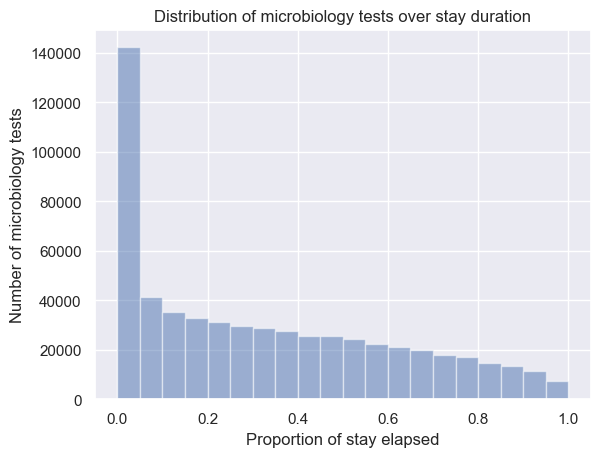

In [21]:
sns.set_theme()
plt.hist(micro_time['PROP_ELAPSED'], alpha=0.5, bins=20)
plt.xlabel('Proportion of stay elapsed')
plt.ylabel('Number of microbiology tests')
plt.title('Distribution of microbiology tests over stay duration')
plt.show()

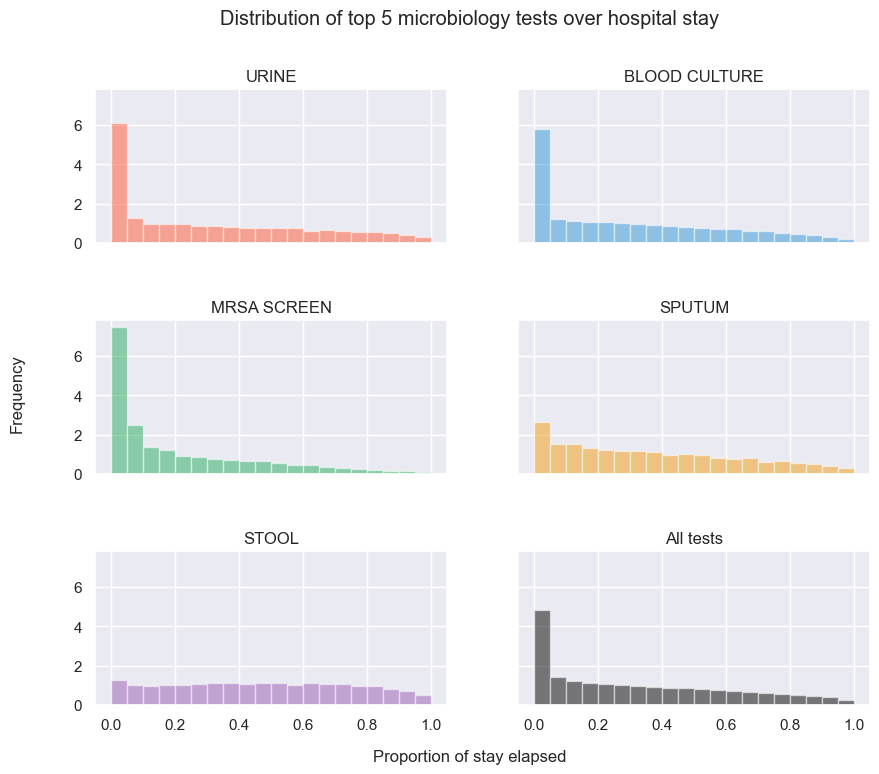

In [48]:
sns.set_theme()
top5_lab = ['URINE', 'BLOOD CULTURE', 'MRSA SCREEN', 'SPUTUM', 'STOOL']
colors = ['#FF5733', '#3498DB', '#27AE60', '#F39C12', '#9B59B6']
fig, axs = plt.subplots(3, 2, figsize=(10,8), sharex=True, sharey=True)  # 2 rows, 2 columns
plt.subplots_adjust(hspace=0.5)
for i in range(5):
    row = i // 2
    col = i % 2
    ax = axs[row, col]

    ax.hist(micro_time[micro_time['LABEL'] == top5_lab[i]]['PROP_ELAPSED'], density=True, bins=20, alpha=0.5, color=colors[i], label=top5_lab[i])
    ax.set_title(f'{top5_lab[i]}')

axs[-1, -1].hist(micro_time['PROP_ELAPSED'], alpha=0.5, bins=20, density=True, color='black')
axs[-1, -1].set_title('All tests')
fig.text(0.5, 0.04, 'Proportion of stay elapsed', ha='center')
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')
plt.suptitle('Distribution of top 5 microbiology tests over hospital stay')
plt.show()

In [39]:
len(list((collections.Counter(micro_time['HADM_ID'].unique()) & collections.Counter(notes_time['HADM_ID'].unique())).elements()))/len(notes_time['HADM_ID'].unique()) * 100

81.40622480245122

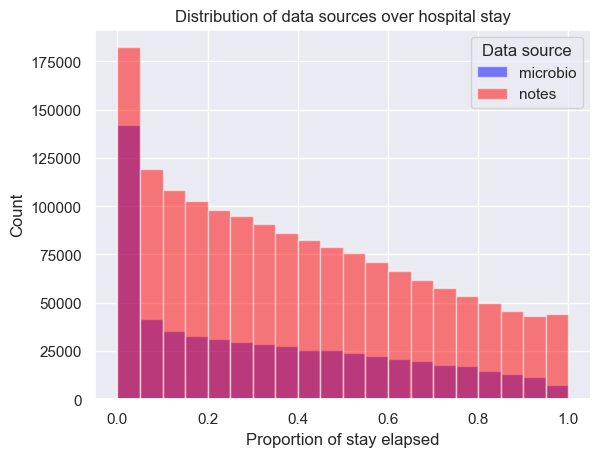

In [21]:
sns.set_theme()
plt.hist(micro_time['PROP_ELAPSED'], bins=20, alpha=0.5, color='blue', label='microbio')
plt.hist(notes_time['PROP_ELAPSED'], bins=20, alpha=0.5, color='red', label='notes')
plt.xlabel('Proportion of stay elapsed')
plt.ylabel('Count')
plt.legend(title='Data source')
plt.title('Distribution of data sources over hospital stay')
plt.show()

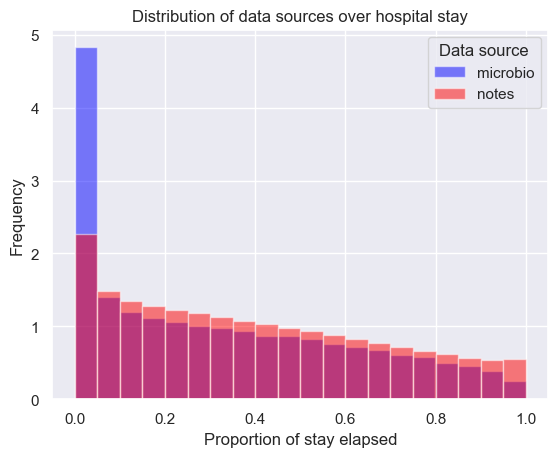

In [20]:
sns.set_theme()
plt.hist(micro_time['PROP_ELAPSED'], density=True, bins=20, alpha=0.5, color='blue', label='microbio')
plt.hist(notes_time['PROP_ELAPSED'], density=True, bins=20, alpha=0.5, color='red', label='notes')
plt.xlabel('Proportion of stay elapsed')
plt.ylabel('Frequency')
plt.legend(title='Data source')
plt.title('Distribution of data sources over hospital stay')
plt.show()

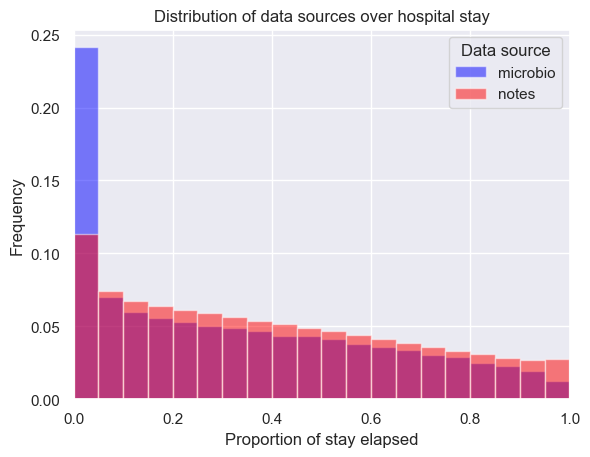

In [25]:
sns.set_theme()
plt.hist(micro_time['PROP_ELAPSED'], weights=np.zeros_like(micro_time['PROP_ELAPSED']) + 1. / micro_time['PROP_ELAPSED'].size, bins=20, alpha=0.5, color='blue', label='microbio')
plt.hist(notes_time['PROP_ELAPSED'], weights=np.zeros_like(notes_time['PROP_ELAPSED']) + 1. / notes_time['PROP_ELAPSED'].size, bins=20, alpha=0.5, color='red', label='notes')
plt.xlim(0,1)
plt.xlabel('Proportion of stay elapsed')
plt.ylabel('Frequency')
plt.legend(title='Data source')
plt.title('Distribution of data sources over hospital stay')
plt.show()

# Mimic IV

In [51]:
dataset_path = os.path.join(project_path, 'mimiciv/hosp')

In [52]:
PATIENTS = pd.read_csv(os.path.join(dataset_path,"patients.csv"))
CXR = pd.read_csv(os.path.join(dataset_path,"cxr-record-list.csv"))

In [53]:
PATIENTS.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN


In [54]:
CXR.head()

,subject_id,study_id,dicom_id,path
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afd...
1,10000032,50414267,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,files/p10/p10000032/s50414267/174413ec-4ec4c1f...
2,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,files/p10/p10000032/s53189527/2a2277a9-b0ded15...
3,10000032,53189527,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,files/p10/p10000032/s53189527/e084de3b-be89b11...
4,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,files/p10/p10000032/s53911762/68b5c4b1-227d048...


In [55]:
len(list((collections.Counter(CXR['subject_id'].unique()) & collections.Counter(PATIENTS['subject_id'].unique())).elements()))/len(PATIENTS['subject_id'].unique()) * 100

20.644151718983558

In [57]:
CXR['subject_id'].nunique()

65379

In [56]:
# get number of studies conducted per patient
CXR.groupby(['subject_id']).count().loc[:, ['study_id']].describe()

,study_id
count,65379.000000
mean,5.768060
std,8.069605
min,1.000000
25%,2.000000
50%,3.000000
75%,6.000000
max,174.000000


In [26]:
# LABEL_SPLITS = pd.read_csv(os.path.join(dataset_path,"LABEL_SPLITS.csv"), dtype={"ICD9_CODE": str})
# NOTEEVENTS = pd.read_csv(os.path.join(dataset_path,"NOTEEVENTS.csv"))
# LABEVENTS = pd.read_csv(os.path.join(dataset_path,"labevents.csv"))
# OUTPUTEVENTS = pd.read_csv(os.path.join(dataset_path,"OUTPUTEVENTS.csv"))
# CHARTEVENTS = pd.read_csv(os.path.join(dataset_path,"CHARTEVENTS.csv"))
# CPTEVENTS = pd.read_csv(os.path.join(dataset_path,"CPTEVENTS.csv"))
# MICROBIOLOGYEVENTS = pd.read_csv(os.path.join(dataset_path,"MICROBIOLOGYEVENTS.csv"))

: 

## Lab Tests
### Summary statistics

In [ ]:
D_LABITEMS = pd.read_csv(os.path.join(dataset_path,"d_labitems.csv"))

In [ ]:
adm_lab = LABEVENTS.merge(D_LABITEMS.loc[:, ['ITEMID', 'LABEL', 'CATEGORY']], on='ITEMID', how='inner').loc[:, ['HADM_ID', 'LABEL', 'CATEGORY', 'CHARTTIME']]
adm_lab = adm_lab.merge(LABEL_SPLITS, on='HADM_ID', how='inner')

### Mapping with time elapsed